# **Step 1 Web Scraping**

In [9]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Lists
phone_name = []
price = []
rating = []
memory_storage = []
display_size = []
camera = []
battery = []

for i in range (2,12):
    # Request
    url = "https://www.flipkart.com/search?q=phone&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page="+str(i)
    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "lxml")
    
    # Find box
    box = soup.find("div", class_="DOjaWF gdgoEp")
    
    # Names
    names = box.find_all("div", class_="KzDlHZ")
    for i in names:
        phone_name.append(i.text)
    
    # Prices
    costs = box.find_all("div", class_="Nx9bqj _4b5DiR")
    for i in costs:
        price.append(i.text)
    
    # Ratings
    ranks = box.find_all("div", class_="XQDdHH")
    for i in ranks:
        rating.append(i.text)
    
    # Features
    mem_feature = box.find_all("ul", class_="G4BRas")
    for ul in mem_feature:
        features = ul.find_all("li", class_="J+igdf")
        memory_storage.append(features[0].text if len(features) > 0 else "N/A")
        display_size.append(features[1].text if len(features) > 1 else "N/A")
        camera.append(features[2].text if len(features) > 2 else "N/A")
        battery.append(features[3].text if len(features) > 3 else "N/A")
    
    # Equalize list lengths
    min_len = min(len(phone_name), len(price), len(rating), len(memory_storage), len(display_size), len(camera), len(battery))

# DataFrame
df = pd.DataFrame({
    "Phone Name": phone_name[:min_len],
    "Rating": rating[:min_len],
    "Price": price[:min_len],
    "Memory": memory_storage[:min_len],
    "Display": display_size[:min_len],
    "Camera": camera[:min_len],
    "Battery": battery[:min_len],
})

# Show result
print(df)

                                      Phone Name Rating    Price  \
0    Samsung Galaxy F06 5G (Bahama Blue, 128 GB)    4.1   ₹8,499   
1            vivo T4x 5G (Pronto Purple, 128 GB)    4.5  ₹14,999   
2       Motorola g45 5G (Brilliant Blue, 128 GB)    4.3  ₹11,999   
3                POCO M7 5G (Mint Green, 128 GB)    4.1   ₹9,499   
4              REDMI 13 5G (Orchid Pink, 128 GB)    4.3  ₹12,499   
..                                           ...    ...      ...   
235         OnePlus 13R 5G (Nebula Noir, 512 GB)    4.5  ₹42,745   
236        OnePlus 13R 5G (Astral Trail, 512 GB)    4.5  ₹42,888   
237             POCO C75 5G (Aqua Bliss, 128 GB)    4.3   ₹8,499   
238      POCO M7 Pro 5G (Lavender Frost, 128 GB)    4.3  ₹12,999   
239      realme P2 Pro 5G (Parrot Green, 256 GB)    4.4  ₹18,750   

                                              Memory  \
0    4 GB RAM | 128 GB ROM | Expandable Upto 1500 GB   
1                              8 GB RAM | 128 GB ROM   
2       8 GB RA

# **Step 2 Storing Scrapped Data**

In [13]:
df.to_csv("phone.csv")

# **Step 3 Data Cleaning**

In [19]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv("phone.csv")

# === Clean the Price column ===
# Remove ₹ and commas, then convert to number
df['Price'] = df['Price'].str.replace('₹', '')  # Remove the currency symbol
df['Price'] = df['Price'].str.replace(',', '')  # Remove commas
df['Price'] = df['Price'].astype(float)        # Convert to float

# If any Price value is missing, fill it with average Price
df['Price'] = df['Price'].fillna(df['Price'].mean())

# === Clean the Rating column ===
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')  # Convert to numeric, non-convertible to NaN
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())      # Fill missing values with the mean

# === Fill missing values in other columns with 'Unknown' ===
for col in ['Memory', 'Display', 'Camera', 'Battery']:
    df[col] = df[col].fillna('Unknown')  # Fill missing values with 'Unknown'

# === Make text lowercase for consistency ===
for col in ['Phone Name', 'Memory', 'Display', 'Camera', 'Battery']:
    df[col] = df[col].str.lower()  # Convert text to lowercase

# === Remove duplicate rows ===
df = df.drop_duplicates()  # Remove duplicate rows

# === Clean the Battery column ===
# Keep only rows that mention "mah"
df = df[df['Battery'].str.contains('mah', na=False)]  # Filter rows containing 'mah'

# Extract just the number part from battery info
def get_battery(text):
    match = re.search(r'(\d+)', text)  # Find the first sequence of digits
    return int(match.group(1)) if match else None  # Return the number if found

df['Battery'] = df['Battery'].apply(get_battery)  # Apply the function to the Battery column

# === Extract numbers from Memory and Display ===
df['Memory'] = df['Memory'].apply(lambda x: re.findall(r'\d+', x)[0] if re.findall(r'\d+', x) else None)
df['Display'] = df['Display'].apply(lambda x: re.findall(r'\d+\.\d+', x)[0] if re.findall(r'\d+\.\d+', x) else None)

# Convert to numbers
df['Memory'] = pd.to_numeric(df['Memory'], errors='coerce')  # Convert Memory to numeric
df['Display'] = pd.to_numeric(df['Display'], errors='coerce')  # Convert Display to numeric

# === Remove outliers using basic rule ===
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)  # First quartile
    q3 = df[column].quantile(0.75)  # Third quartile
    iqr = q3 - q1  # Interquartile range
    lower = q1 - 1.5 * iqr  # Lower bound
    upper = q3 + 1.5 * iqr  # Upper bound
    return df[(df[column] >= lower) & (df[column] <= upper)]  # Filter out outliers

# Remove outliers from numeric columns
for col in ['Price', 'Rating', 'Memory', 'Display', 'Battery']:
    df = remove_outliers(df, col)

# === Save cleaned data to a new file ===
df.to_csv("cleaned_phone_data.csv", index=False)  # Save the cleaned DataFrame to a CSV file

# Show final cleaned data
print(df)

     Unnamed: 0                                   Phone Name  Rating    Price  \
0             0  samsung galaxy f06 5g (bahama blue, 128 gb)     4.1   8499.0   
3             3              poco m7 5g (mint green, 128 gb)     4.1   9499.0   
4             4            redmi 13 5g (orchid pink, 128 gb)     4.3  12499.0   
5             5   cmf by nothing phone 2 pro (white, 128 gb)     4.4  18999.0   
6             6   samsung galaxy f06 5g (bahama blue, 64 gb)     4.1   7999.0   
..          ...                                          ...     ...      ...   
231         231           vivo t3 5g (crystal flake, 256 gb)     4.4  18999.0   
233         233   cmf by nothing phone 2 pro (white, 256 gb)     4.4  20999.0   
234         234   cmf by nothing phone 2 pro (black, 256 gb)     4.4  20999.0   
237         237             poco c75 5g (aqua bliss, 128 gb)     4.3   8499.0   
238         238      poco m7 pro 5g (lavender frost, 128 gb)     4.3  12999.0   

     Memory  Display       

# **Step 4 Exploratory Data Analysis**

   Unnamed: 0                                   Phone Name  Rating    Price  \
0           0  samsung galaxy f06 5g (bahama blue, 128 gb)     4.1   8499.0   
1           3              poco m7 5g (mint green, 128 gb)     4.1   9499.0   
2           4            redmi 13 5g (orchid pink, 128 gb)     4.3  12499.0   
3           5   cmf by nothing phone 2 pro (white, 128 gb)     4.4  18999.0   
4           6   samsung galaxy f06 5g (bahama blue, 64 gb)     4.1   7999.0   

   Memory  Display                                 Camera  Battery  
0       4    17.02          50mp + 2mp | 8mp front camera     5000  
1       6    17.48    50mp rear camera | 8mp front camera     5160  
2       6    17.25        108mp + 2mp | 13mp front camera     5030  
3       8    17.20  50mp + 50mp + 8mp | 16mp front camera     5000  
4       4    17.02          50mp + 2mp | 8mp front camera     5000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 8 columns):
 #   Co

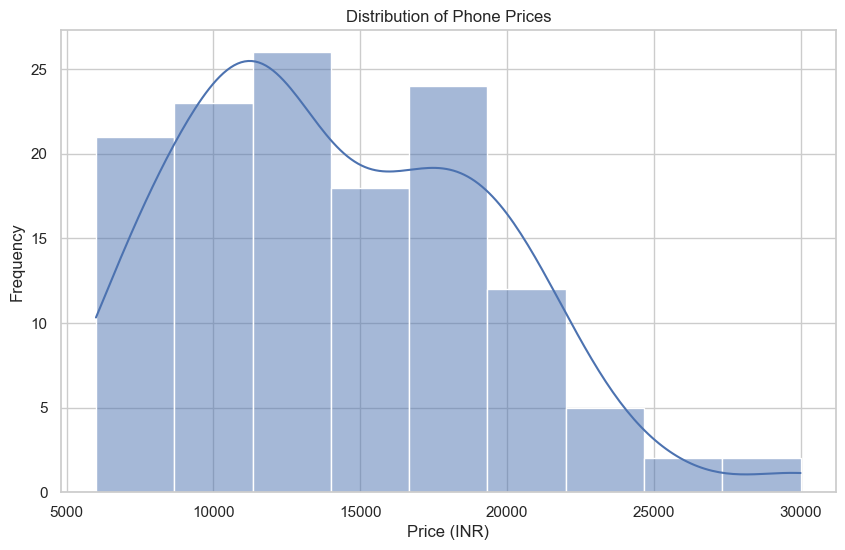

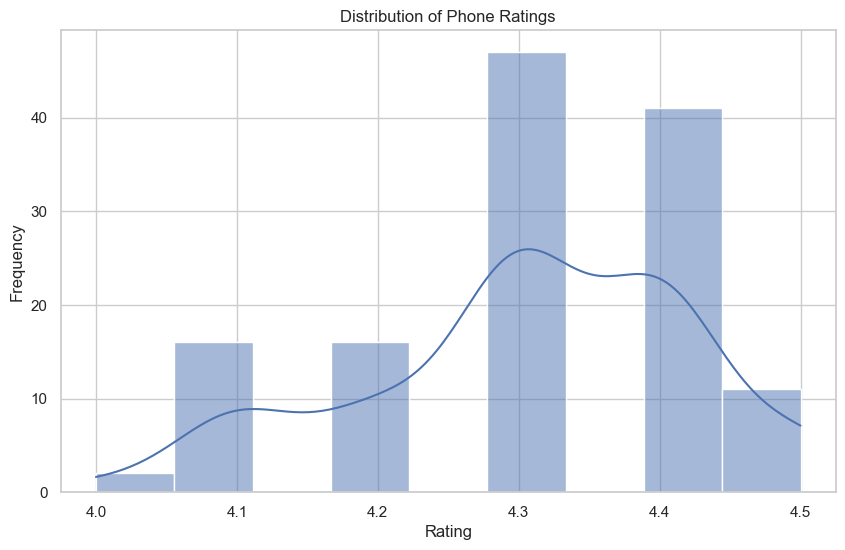

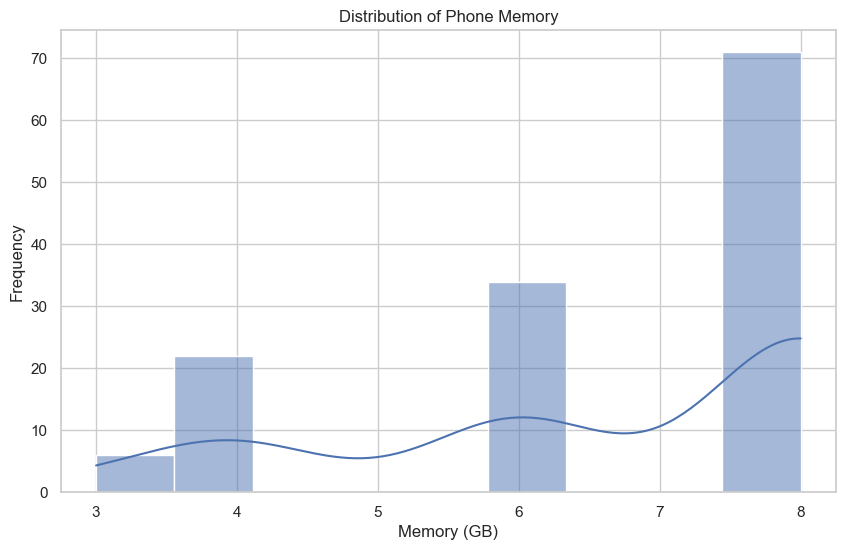

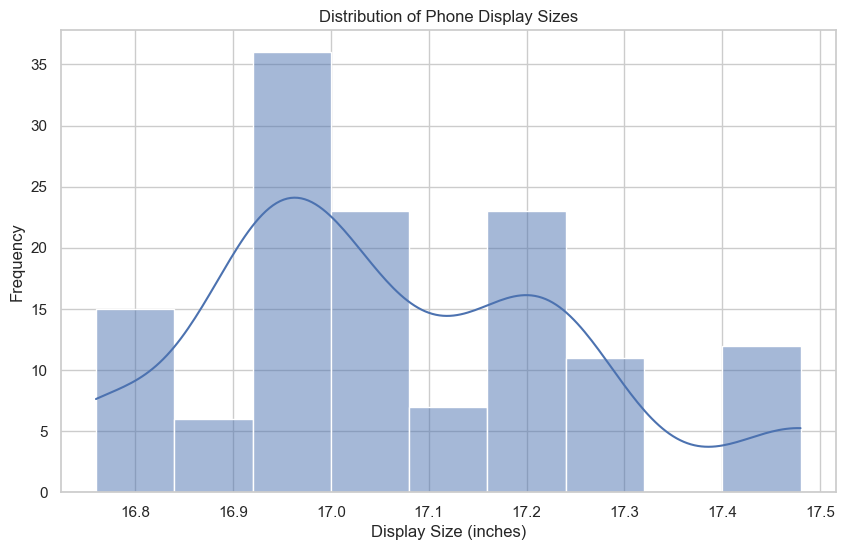

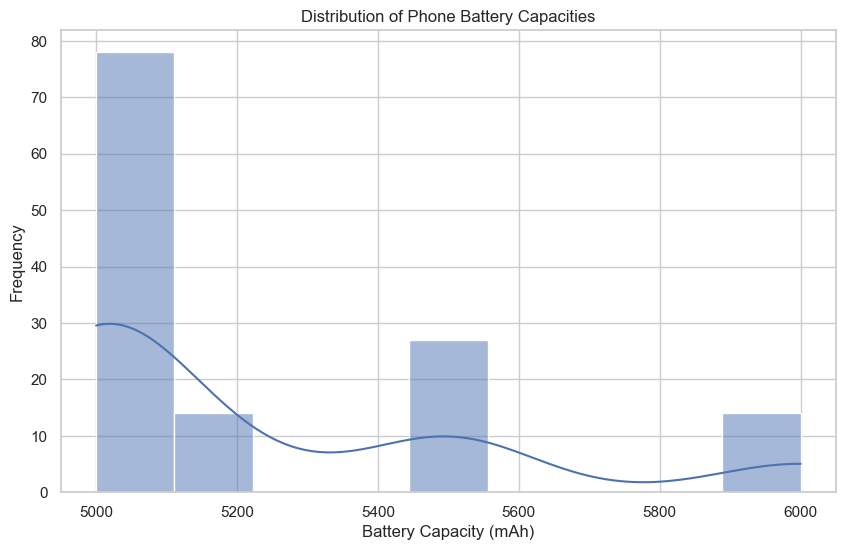

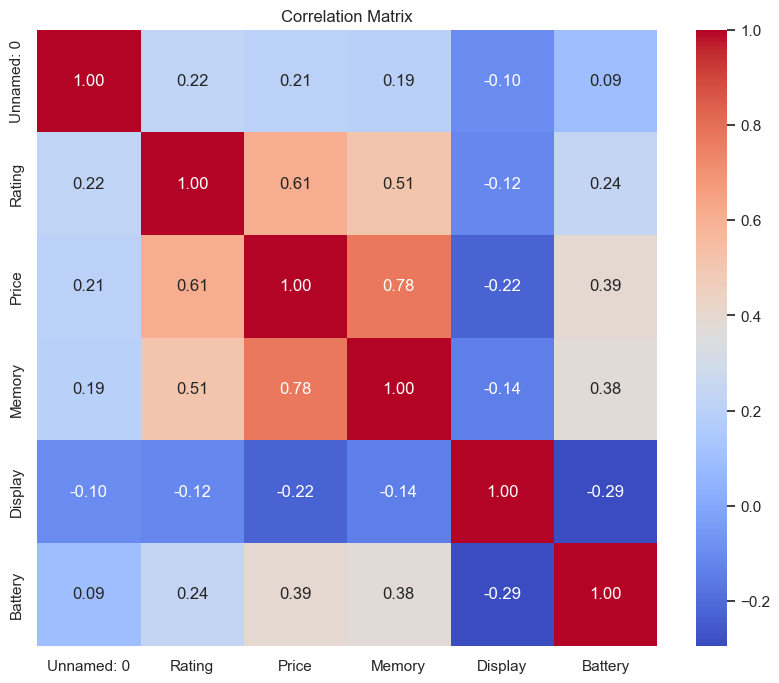

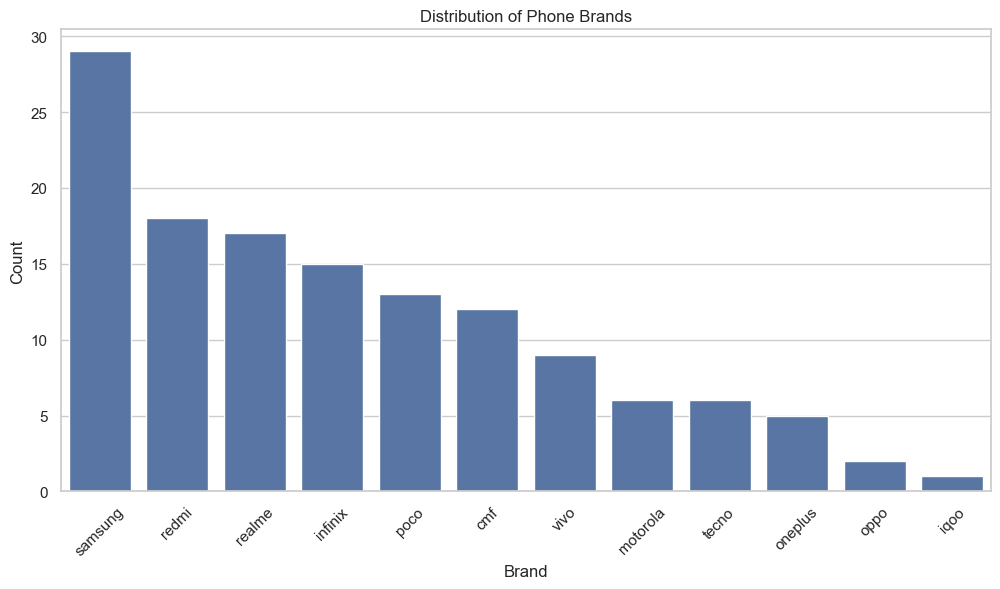

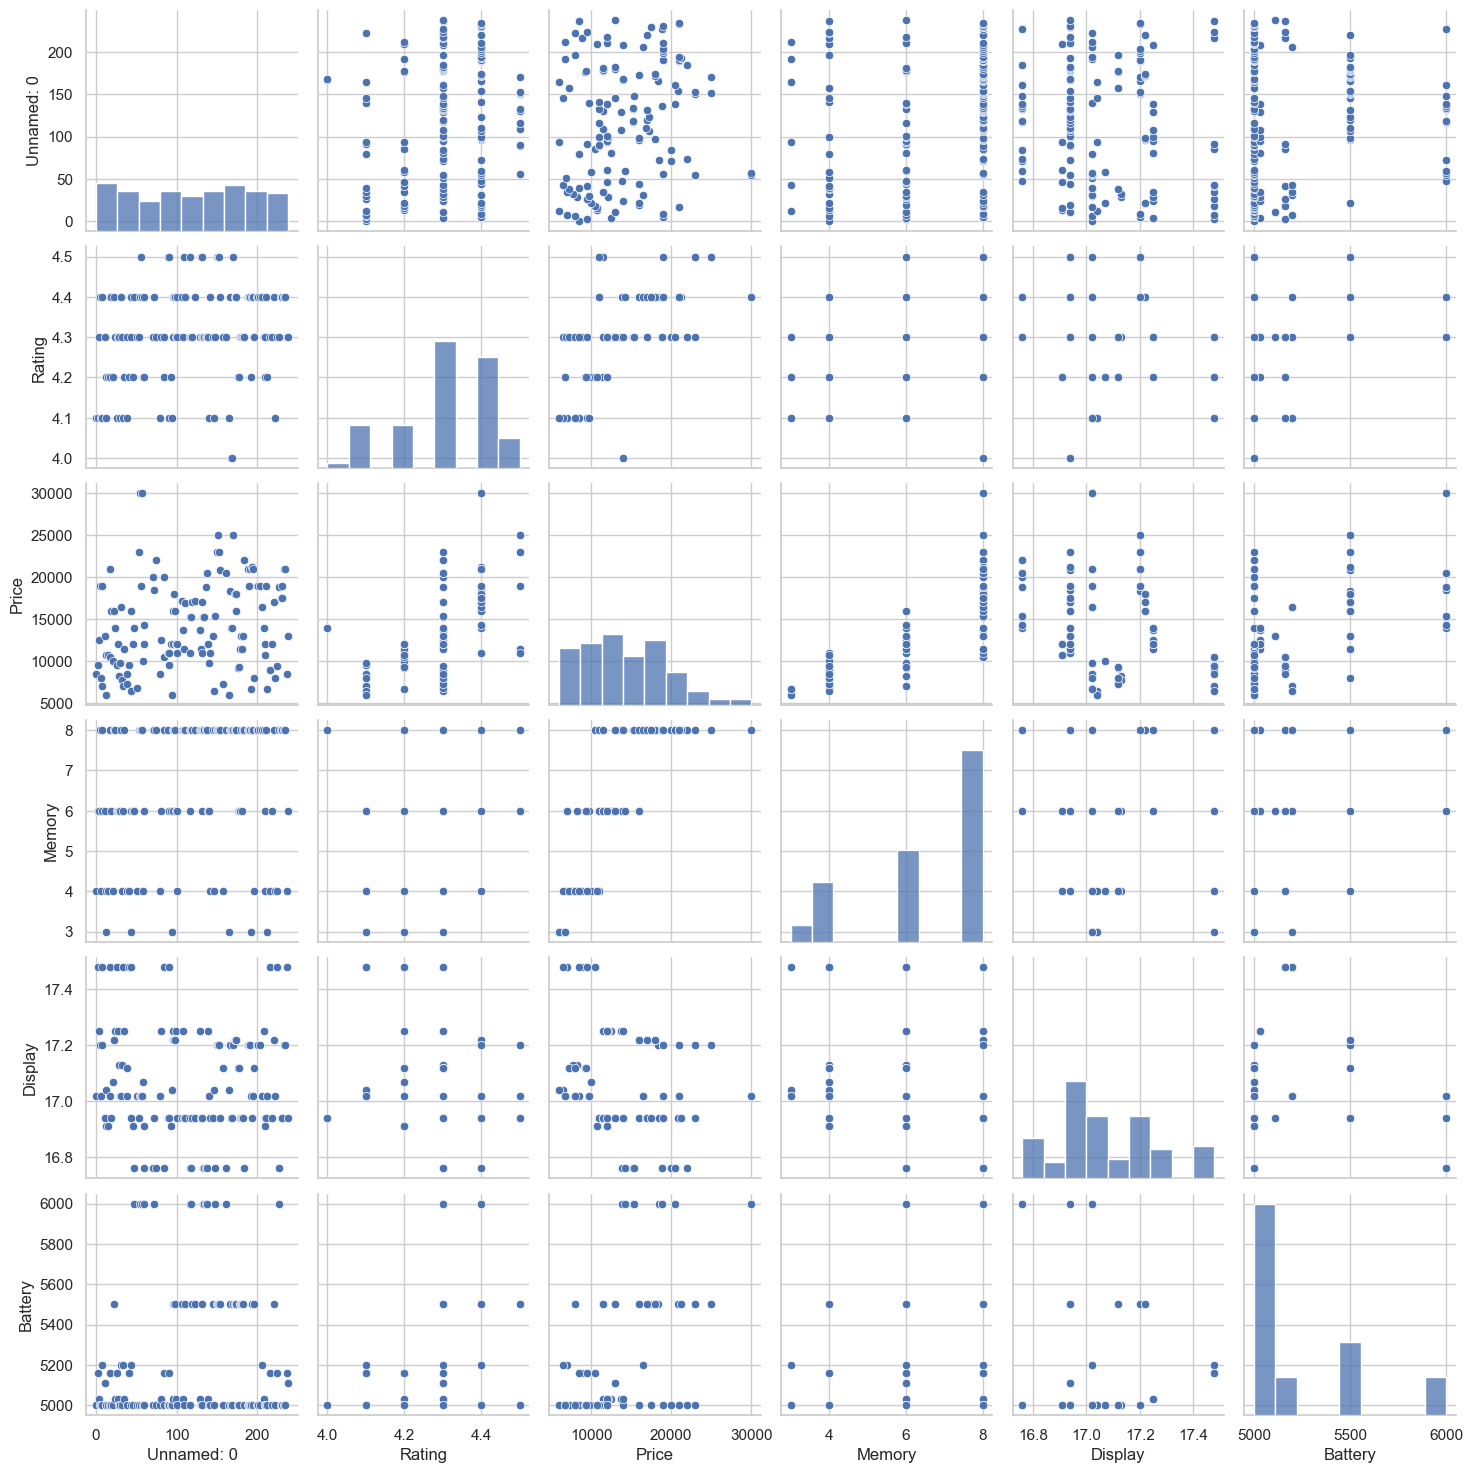

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("cleaned_phone_data.csv")

# Display the first few rows of the DataFrame
print(df.head())

# Get a summary of the DataFrame
print(df.info())

# Get descriptive statistics for numerical columns
print(df.describe())

# Set the style for seaborn
sns.set(style="whitegrid")

# === Visualize Data Distributions ===

# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Phone Prices')
plt.xlabel('Price (INR)')
plt.ylabel('Frequency')
plt.show()

# Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of Phone Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Memory Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Memory'], kde=True)
plt.title('Distribution of Phone Memory')
plt.xlabel('Memory (GB)')
plt.ylabel('Frequency')
plt.show()

# Display Size Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Display'], kde=True)
plt.title('Distribution of Phone Display Sizes')
plt.xlabel('Display Size (inches)')
plt.ylabel('Frequency')
plt.show()

# Battery Capacity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Battery'], kde=True)
plt.title('Distribution of Phone Battery Capacities')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Frequency')
plt.show()

# === Identify Correlations ===

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# === Categorical Analysis ===

# Example: Distribution of Phone Brands
df['Brand'] = df['Phone Name'].apply(lambda x: x.split()[0])
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Brand', order=df['Brand'].value_counts().index)
plt.title('Distribution of Phone Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# === Pairwise Relationships ===

# Pairplot to visualize pairwise relationships
sns.pairplot(df[numerical_columns])
plt.show()

# *Key Findings (Observations)*
### Price Distribution: 
   Most phones are affordable, but a few high-end models are much pricier, making the market lean towards budget options.

### Rating Distribution
- Most phones have good user ratings.
- **Average rating is around 4.0**.

### Memory Distribution
- The market is dominated by phones with **moderate memory capacities**.

###  Display Size Distribution
- Most phones have display sizes between **6 and 7 inches**.

### Battery Capacity Distribution
- Phones with **battery capacities around 5000 mAh** are common.

### Correlation Matrix
- **Price and memory** are **positively correlated**.
- **Larger batteries** might slightly increase phone prices.
- **User ratings** aren't strongly influenced by other features.

###  Distribution of Phone Brands
- Some brands have **more models listed** than others, showing varying product strategies.

### Pairwise Relationships
- Phones with **higher memory tend to be more expensive**.
